In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scikits.odes.ode import ode
import time
import seaborn as sns

from scipy.optimize import minimize
from scipy.optimize import Bounds
import time

In [2]:
#Import local functions
sys.path.append('../functions')
from functions import nonlinearity, repression, activation

In [27]:
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def dual_control_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss
        
    solution = ode('cvode', dual_control_sundials, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [48]:
#RUN FOR UR
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def upstream_repression_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
        ydot[3] = k2 - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = repression(y[1], k1, theta1, n1)

    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss
        
    solution = ode('cvode', upstream_repression_sundials, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [56]:
#RUN FOR DA
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    
    alpha1 = 1E-5
    alpha2 = 1E-2

    int_time = 5E4
    t = np.linspace(0, int_time, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

    def downstream_activation_sundials(t, y, ydot):
        kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
        ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
        ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
        ydot[2] = k1 - lam*y[2]
        ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
        ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
        ydot[5] = activation(y[1], k2, theta2, n2)


    def loss_biological(j1, j2, alpha1, alpha2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss
        
    solution = ode('cvode', downstream_activation_sundials, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return loss

In [57]:
def solve_patch_6d(init_conds, patch_size, step_sizes):
    n1, n2, theta1, theta2, k1, k2 = init_conds
    center_loss = solve_point(init_conds)
    #Sample randomly from hypersphere
    normal_deviates = np.random.normal(size=(6, patch_size))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    points = normal_deviates/radius

    scaled_points = []
    for i in range(patch_size):
        scaled_points.append(list(step_sizes*points[:, i]  + init_conds))
    scaled_points = np.array(scaled_points)
    
    min_loss = center_loss
    new_k1 = k1; new_k2 = k2; new_theta1 = theta1; new_theta2 = theta2; new_n1 = n1; new_n2 = n2
    for n1, n2, theta1, theta2, k1, k2 in zip(scaled_points[:, 0], scaled_points[:, 1], scaled_points[:, 2], scaled_points[:, 3], scaled_points[:, 4], scaled_points[:, 5]):
        loss = solve_point([n1, n2, theta1, theta2, k1, k2])
        if bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
            if loss < min_loss:
                new_k1 = k1
                new_k2 = k2
                new_theta1 = theta1
                new_theta2 = theta2
                new_n1 = n1
                new_n2 = n2
                min_loss = loss
    return new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, min_loss

In [58]:
def bounds_check_6d(n1, n2, theta1, theta2, k1, k2):
    if k1 <= 1E-3 and k2 <= 1E-3 and k1 >= 1E-7 and k2 >= 1E-7:
        if n1 <= 4 and n2 <= 4 and n1 >= 1 and n2 >= 1:
            if theta1 >= 0.001 and theta2 >= 0.001 and theta1 <= 100 and theta2 <= 100:
                return True
    else: return False

In [69]:
num_epochs = 100
tolerance = 0.0004

init_conds = np.array([2,2,0.1, 0.1, 0.001, 0.001])
patch_size = 100
step_sizes = np.array([0.1, 0.1, 0.01, 0.01, 0.0001, 0.0001])
solve_patch_6d(init_conds, patch_size, step_sizes)

next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2, loss = solve_patch_6d(init_conds, patch_size, step_sizes)

losses = [loss]; k1_trace = [next_k1]; k2_trace = [next_k2]; n1_trace = [next_n1]; n2_trace = [next_n2]; theta1_trace = [next_theta1]; theta2_trace = [next_theta2]

for i in range(num_epochs):
    new_n1, new_n2, new_theta1, new_theta2, new_k1, new_k2, loss = solve_patch_6d([next_n1, next_n2, next_theta1, next_theta2, next_k1, next_k2], patch_size, step_sizes)
    next_k1 = new_k1
    next_k2 = new_k2
    next_theta1 = new_theta1
    next_theta2 = new_theta2
    next_n1 = new_n1
    next_n2 = new_n2

    print('Epoch: ', i, 'Loss: ', loss)
    losses.append(loss)
    k1_trace.append(new_k1)
    k2_trace.append(new_k2)
    n1_trace.append(new_n1)
    n2_trace.append(new_n2)
    theta1_trace.append(new_theta1)
    theta2_trace.append(new_theta2)

    if losses[-2] - losses[-1] < tolerance:
        print('Terminating early at step', i, 'of ', num_epochs)
        break

Epoch:  0 Loss:  1098.0179271814516
Epoch:  1 Loss:  891.8794957630569
Epoch:  2 Loss:  734.5042663474167
Epoch:  3 Loss:  549.2140215370579
Epoch:  4 Loss:  392.71930794882314
Epoch:  5 Loss:  273.54965536485105
Epoch:  6 Loss:  169.53869839850904
Epoch:  7 Loss:  92.97784516220135
Epoch:  8 Loss:  37.85740917836433
Epoch:  9 Loss:  9.2354206878334
Epoch:  10 Loss:  0.42036599069281366


/Users/charlotte/Library/Mobile Documents/com~apple~CloudDocs/Documents/PhD/Thesis/msc-thesis/no_backprop_6D/../functions/functions.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return (k*(x/theta)**n)/(1+(x/theta)**n)

[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence

Epoch:  11 Loss:  0.40008219883309376



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  12 Loss:  0.37247462290896033



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  13 Loss:  0.3519917431857097



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  14 Loss:  0.3297221189154429



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  15 Loss:  0.31501110516109926



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  16 Loss:  0.2975055168405245



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  17 Loss:  0.27358467154830474



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  18 Loss:  0.23541621900679874



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  19 Loss:  0.2116826745309723



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  20 Loss:  0.1836266756508948



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  21 Loss:  0.1580122017420162



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  22 Loss:  0.11583385879244243



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  23 Loss:  0.08881269290277434



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  24 Loss:  0.05073302853507722



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  25 Loss:  0.03479976167039244



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13

Epoch:  26 Loss:  0.033215595700354844
Epoch:  27 Loss:  0.033215595700354844
Terminating early at step 27 of  100



[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.


[CVODE ERROR]  CVode
  At t = 3.34879e-12 and h = 1.27746e-13, the corrector convergence test failed repeatedly or with |h| = hmin.



In [31]:
#ur_results = pd.DataFrame({'k1': k1_trace, 'k2': k2_trace,'n1': n1_trace,'n2': n2_trace,'theta1': theta1_trace,'theta2': theta2_trace,'loss': losses})
#da_results = pd.DataFrame({'k1': k1_trace, 'k2': k2_trace,'n1': n1_trace,'n2': n2_trace,'theta1': theta1_trace,'theta2': theta2_trace,'loss': losses})
#dc_results = pd.DataFrame({'k1': k1_trace, 'k2': k2_trace,'n1': n1_trace,'n2': n2_trace,'theta1': theta1_trace,'theta2': theta2_trace,'loss': losses})


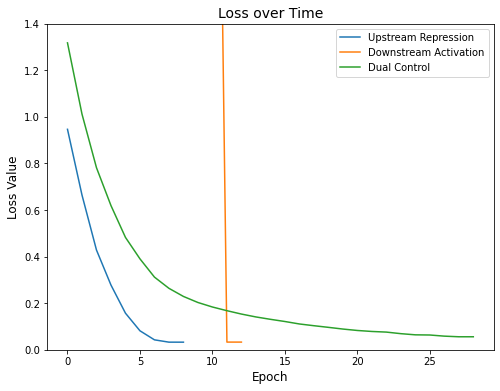

In [46]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

endpoint = 'Loss over Time'
ax = axs
ax.plot(ur_results.loss, label='Upstream Repression')
ax.plot(da_results.loss, label='Downstream Activation')
ax.plot(dc_results.loss, label='Dual Control')
ax.set_ylim([0, 1.4])
#ax.set_yscale('log')
ax.legend()

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)
fig.savefig('combined_loss_linear_da_removed.png')

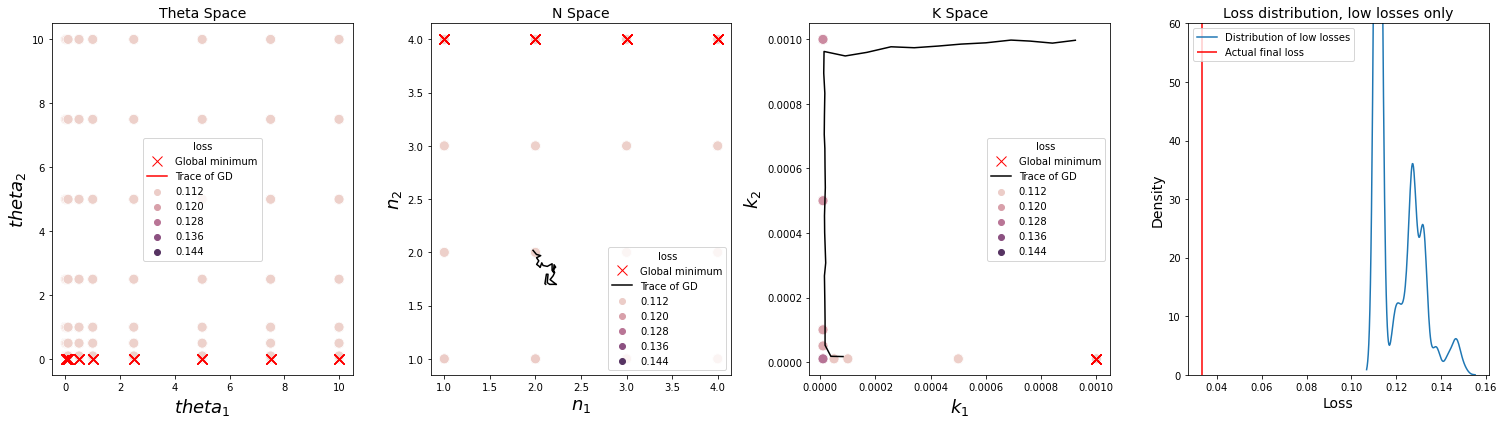

In [70]:
#Plot local minima of space
true_landscape = pd.read_csv('../6d_loss_landscape/da_landscape_sundials.csv')

landscape = true_landscape.loc[true_landscape.theta1 != 100].loc[true_landscape.theta2 != 100]
min_loss = landscape.loss.min()
tolerance = 0.04

low_loss = landscape.loc[landscape.loss < min_loss + tolerance]
min_loss_landscape = landscape.loc[landscape.loss == min_loss]
fig, axs = plt.subplots(1, 4, figsize=(21, 6))

endpoint = 'Theta Space'
ax = axs[0]
ax.plot(min_loss_landscape.theta1, min_loss_landscape.theta2, 'rx', markersize=10, label='Global minimum')
ax.plot(theta1_trace, theta2_trace, 'r-', label='Trace of GD')
sns.scatterplot(x='theta1', y='theta2', data = low_loss, hue='loss', ax=ax, s=100)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('$theta_1$', fontsize=18)
ax.set_ylabel('$theta_2$', fontsize=18)


endpoint = 'N Space'
ax = axs[1]
ax.plot(min_loss_landscape.n1, min_loss_landscape.n2, 'rx', markersize=10, label='Global minimum')
ax.plot(n1_trace, n2_trace, 'k-', label='Trace of GD')
sns.scatterplot(x='n1', y='n2', data = low_loss, hue='loss', ax=ax , s=100)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('$n_1$', fontsize=18)
ax.set_ylabel('$n_2$', fontsize=18)

endpoint = 'K Space'
ax = axs[2]
ax.plot(min_loss_landscape.k1, min_loss_landscape.k2, 'rx', markersize=10, label='Global minimum')
ax.plot(k1_trace, k2_trace, 'k-', label='Trace of GD')

sns.scatterplot(x='k1', y='k2', data = low_loss, hue='loss', ax=ax, s=100)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('$k_1$', fontsize=18)
ax.set_ylabel('$k_2$', fontsize=18)

endpoint = 'Loss distribution, low losses only'
ax = axs[3]
sns.kdeplot(low_loss.loss, ax=ax, label='Distribution of low losses')
ax.vlines(losses[-1], 0, 200, colors='r', label='Actual final loss')
ax.set_ylim([0, 60])
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Loss', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
fig.tight_layout()
fig.savefig('low_losses_exploration_with_trace_da.png')
